In [1]:
import scipy.io as sio
import numpy as np
import glob
from keras import applications, optimizers, callbacks, Model
from keras.models import Sequential, clone_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Prepare training data
1. Paddle two empty channels to get 3-channel input
2. Pair input data with training label (emittance)

In [3]:
# load Ronchigrams with noise and emittance values
x_train_list = []
y_train_list = []
input_path = '../RonchigramSimulation/ronchigram-matlab-master/TestData/'
input_path = ''
train_data = np.load(input_path + 'FullRandom_70aperture_100limit_128px_1us_30pA_128pxRonch_5000x.npy')
train_label = np.load(input_path + 'FullRandom_70aperture_100limit_128px_1us_30pA_emit_5000x.npy')
train_label = np.log(train_label)
# train_label = (train_label - np.amin(train_label))/ (np.amax(train_label) - np.amin(train_label))

In [4]:
# pad extra layers to get 3-channel image
for i in range(train_data.shape[0]):
    frame = scale_range(train_data[i,:,:].astype('float'), 0, 1)
    new_channel = np.zeros(frame.shape)
    img_stack = np.dstack((frame, new_channel, new_channel))
    x_train_list.append(img_stack)
    y_train_list.append(train_label[i])

In [5]:
x_train = np.concatenate([arr[np.newaxis] for arr in x_train_list])
y_train = np.asarray(y_train_list,dtype=np.float32)
del x_train_list, y_train_list, train_data, train_label

(5000, 128, 128, 3)
[19.429417 22.426798 21.807903 ... 24.178532 22.955957 23.258034]


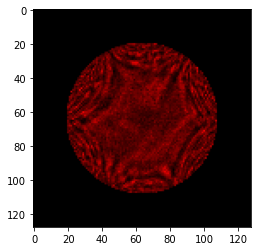

In [6]:
print(x_train.shape)
plt.imshow(x_train[1000,:,:,:])
print(y_train)

In [14]:
# Train top fully connected layers
batch_size = 40
epochs = 100
nb_train_samples = x_train.shape[0]
max_index = 0

model = applications.DenseNet121(include_top=False, weights='imagenet')
print('before featurewise center')
    
datagen = ImageDataGenerator(
    featurewise_center=True,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=1,
    vertical_flip=1,
    shear_range=0.05)

datagen = ImageDataGenerator(
    featurewise_center=True)

datagen.fit(x_train)
print('made it past featurewise center')
generator = datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size,
    shuffle=False)
print('made it past generator')

bottleneck_features_train = model.predict_generator(
    generator, nb_train_samples // batch_size)

print('made it past the bottleneck features')
# np.save('bottleneck_features_train.npy',bottleneck_features_train)

train_data = bottleneck_features_train
train_labels = y_train
print(train_data.shape, train_labels.shape)
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(nb_class, activation='relu'))
model.add(Dense(1,activation=None))

# compile setting:
lr = 1e-5
decay = 1e-4
momentum = 0.9
optimizer = optimizers.SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True)
loss = 'mse'
model.compile(optimizer=optimizer, loss=loss, metrics=['mse'])

bottleneck_log = 'training_' + str(max_index) + '_bnfeature_log.csv'
csv_logger_bnfeature = callbacks.CSVLogger(bottleneck_log)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=30, verbose=1, mode='auto')

model.fit(train_data,train_labels,epochs=epochs,batch_size=batch_size,shuffle=True,
        callbacks=[csv_logger_bnfeature, earlystop],verbose=2,validation_split=0.2)

with open(bottleneck_log, 'a') as log:
    log.write('\n')
    log.write('input images: ' + '\n')
    log.write('batch_size:' + str(batch_size) + '\n')
    log.write('learning rate: ' + str(lr) + '\n')
    log.write('learning rate decay: ' + str(decay) + '\n')
    log.write('momentum: ' + str(momentum) + '\n')
    log.write('loss: ' + loss + '\n')

model.save_weights('top_layers.h5')

before featurewise center
made it past featurewise center
made it past generator
made it past the bottleneck features
(5000, 4, 4, 1024) (5000,)
Train on 4000 samples, validate on 1000 samples
Epoch 1/100
 - 1s - loss: 12.2826 - mse: 12.2826 - val_loss: 1.5133 - val_mse: 1.5133
Epoch 2/100
 - 1s - loss: 3.2799 - mse: 3.2799 - val_loss: 1.2085 - val_mse: 1.2085
Epoch 3/100
 - 1s - loss: 2.7799 - mse: 2.7799 - val_loss: 1.1999 - val_mse: 1.1999
Epoch 4/100
 - 1s - loss: 2.3850 - mse: 2.3850 - val_loss: 0.9570 - val_mse: 0.9570
Epoch 5/100
 - 1s - loss: 2.3438 - mse: 2.3438 - val_loss: 0.8218 - val_mse: 0.8218
Epoch 6/100
 - 1s - loss: 2.1778 - mse: 2.1778 - val_loss: 0.8034 - val_mse: 0.8034
Epoch 7/100
 - 1s - loss: 2.0944 - mse: 2.0944 - val_loss: 0.7674 - val_mse: 0.7674
Epoch 8/100
 - 1s - loss: 2.0134 - mse: 2.0134 - val_loss: 0.7587 - val_mse: 0.7587
Epoch 9/100
 - 1s - loss: 1.9035 - mse: 1.9035 - val_loss: 0.8101 - val_mse: 0.8101
Epoch 10/100
 - 1s - loss: 1.8932 - mse: 1.8932 -

Epoch 96/100
 - 1s - loss: 1.4185 - mse: 1.4185 - val_loss: 0.4400 - val_mse: 0.4400
Epoch 97/100
 - 1s - loss: 1.4036 - mse: 1.4036 - val_loss: 0.4380 - val_mse: 0.4380
Epoch 98/100
 - 1s - loss: 1.4070 - mse: 1.4070 - val_loss: 0.4383 - val_mse: 0.4383
Epoch 99/100
 - 1s - loss: 1.3557 - mse: 1.3557 - val_loss: 0.4492 - val_mse: 0.4492
Epoch 100/100
 - 1s - loss: 1.4271 - mse: 1.4271 - val_loss: 0.4492 - val_mse: 0.4492


In [9]:
{i: v for i, v in enumerate(model.layers)}

{0: <keras.engine.input_layer.InputLayer at 0x2c324e4a2e8>,
 1: <keras.layers.convolutional.ZeroPadding2D at 0x2c324e4a160>,
 2: <keras.layers.convolutional.Conv2D at 0x2c324e4a470>,
 3: <keras.layers.normalization.BatchNormalization at 0x2c600efa2e8>,
 4: <keras.layers.core.Activation at 0x2c600f263c8>,
 5: <keras.layers.convolutional.ZeroPadding2D at 0x2c600ece0b8>,
 6: <keras.layers.pooling.MaxPooling2D at 0x2c600ece358>,
 7: <keras.layers.normalization.BatchNormalization at 0x2c600db37b8>,
 8: <keras.layers.core.Activation at 0x2c600afe208>,
 9: <keras.layers.convolutional.Conv2D at 0x2c600ad60f0>,
 10: <keras.layers.normalization.BatchNormalization at 0x2c600739048>,
 11: <keras.layers.core.Activation at 0x2c6006ce278>,
 12: <keras.layers.convolutional.Conv2D at 0x2c6005ceac8>,
 13: <keras.layers.merge.Concatenate at 0x2c60049fac8>,
 14: <keras.layers.normalization.BatchNormalization at 0x2c60049f518>,
 15: <keras.layers.core.Activation at 0x2c600437c50>,
 16: <keras.layers.convol

In [15]:
# Fine tune the whole model
model = applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
print('Model loaded')
# Create a sequential model to load the weights
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.2))
top_model.add(Dense(1,activation=None))
top_model.load_weights('top_layers.h5')
# Create separate layers and put it on top of the Resnet nodel
x = Flatten()(model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation = None)(x)
model = Model(inputs=model.inputs, output=x)
# Set the weights of two dense layers in the final model to the pre-trained top
model.get_layer(index = 428).set_weights(top_model.get_layer(index = 1).get_weights())
model.get_layer(index = 430).set_weights(top_model.get_layer(index = 3).get_weights())

Model loaded


C:\Users\zhang\Anaconda3\envs\STEM\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [16]:
# Set up CNN training parameters
# compile settings
lr = 0.000055
decay = 1e-7
momentum = 0.9
optimizer = optimizers.SGD(lr=lr, decay=decay, momentum=momentum, nesterov=True)
loss = 'mse'
model.compile(optimizer=optimizer, loss=loss, metrics=['mse'])
batch_size = 30
epochs = 50
bottleneck_log = 'test.csv'
csv_logger = callbacks.CSVLogger(bottleneck_log)

datagen = ImageDataGenerator(
        featurewise_center=True,
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=1,
        vertical_flip=1,
        shear_range=0.05)

datagen.fit(x_train)

generator = datagen.flow(
        x_train,
        y_train,
        batch_size=batch_size,
        shuffle=True)

validation_generator = datagen.flow(
        x_train,
        y_train,
        batch_size=batch_size,
        shuffle=True)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=1, mode='auto')

In [ ]:
model.fit_generator(generator,epochs=epochs,steps_per_epoch=len(train_data) / 30,validation_data=validation_generator,validation_steps=(len(train_data)//5)//30,
            callbacks=[csv_logger, earlystop],verbose=2)

In [16]:
x_validation = x_train[0:1000,:,:,:]
y_pred = new_model.predict(x_validation, batch_size = 25)
y_truth = y_train[0:1000]

In [24]:
y_max

25.208101

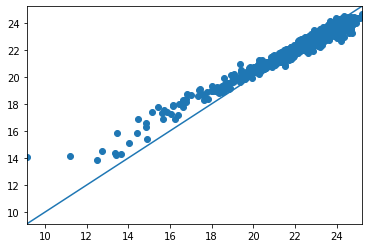

In [27]:
y_min = np.amin(y_truth)
y_max = np.amax(y_truth)

plt.scatter(y_truth, y_pred)
plt.xlim([y_min,y_max])
plt.ylim([y_min,y_max])
plt.plot(np.linspace(y_min,y_max,num=1000),np.linspace(y_min,y_max,num=1000))

## Functions

In [2]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input  